In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# Set the directory path
directory_path = '/content/drive/MyDrive/5370 Data'




Mounted at /content/drive


In [ ]:
SH = pd.read_csv('/content/drive/MyDrive/000001.SS.csv', usecols=['Date', 'Close'])
SH['Date'] = pd.to_datetime(SH['Date']).dt.strftime('%m/%d/%Y')
SH.columns = ['Date', 'Closing Price']

##Preparing the Data

In [ ]:
from datetime import datetime
asset_dataframes = {}

for file in os.listdir(directory_path):
    if file.endswith('.xlsx') and "PMI&CPI" not in file:
        file_path = os.path.join(directory_path, file)
        asset_name = os.path.splitext(file)[0]
        df = pd.read_excel(file_path, usecols=['交易日期', '收盘价'])

        df = df[df["交易日期"] != "数据来源：Wind"]
        df.columns = ["Date", "Closing Price"]
        # Convert to datetime and remove time component
        df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%m/%d/%Y')
        asset_dataframes[asset_name] = df

asset_dataframes['SH'] = SH
all_dates = []
for asset_name, df in asset_dataframes.items():
    all_dates.append(list(df['Date']))
all_dates = [[datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in list] for list in all_dates]

# Find common dates among all assets
common_dates = list(set.intersection(*map(set, all_dates)))

#print("Common Dates:", common_dates)



In [ ]:
import pandas as pd


common_dates = sorted(common_dates)

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame({'Date': common_dates})
combined_data.set_index('Date', inplace=True)

for asset_name, df in asset_dataframes.items():

    df['Date'] = pd.to_datetime(df['Date'])
    asset_prices = df[df['Date'].isin(common_dates)]['Closing Price']

    asset_prices.index = df.loc[df['Date'].isin(common_dates), 'Date']
    asset_prices.rename(asset_name, inplace=True)

    # Merge the asset data with the combined_data DataFrame using common dates
    combined_data = pd.merge(combined_data, asset_prices, left_index=True, right_index=True, how='left')

#print(combined_data)


In [ ]:
print(combined_data.columns)

Index(['0-3mon', '0-10yr', '3-5yr', '7-10yr', '10yr', '30yr', 'Colored Metal',
       'Agri', 'Chemical', 'Iron', 'Electronics', 'Vehicle',
       'Household Appliances', 'Food and Beverage', 'Textile',
       'Light Industry Manufacturing', 'Healthcare', 'Public Affair',
       'Transportation', 'Real Estate', 'Consumer', 'Social Service', 'Bank',
       'Financial Service', 'General', 'Building Materials',
       'Architectural Decoration', 'Power Equipment', 'Mechanical', 'Military',
       'Computer', 'Media', 'Telecommunication', 'Coal', 'Petrochemical',
       'Environmental', 'Beauty', 'Corporate_Bond_30_Index', 'High Yield',
       'SH'],
      dtype='object')


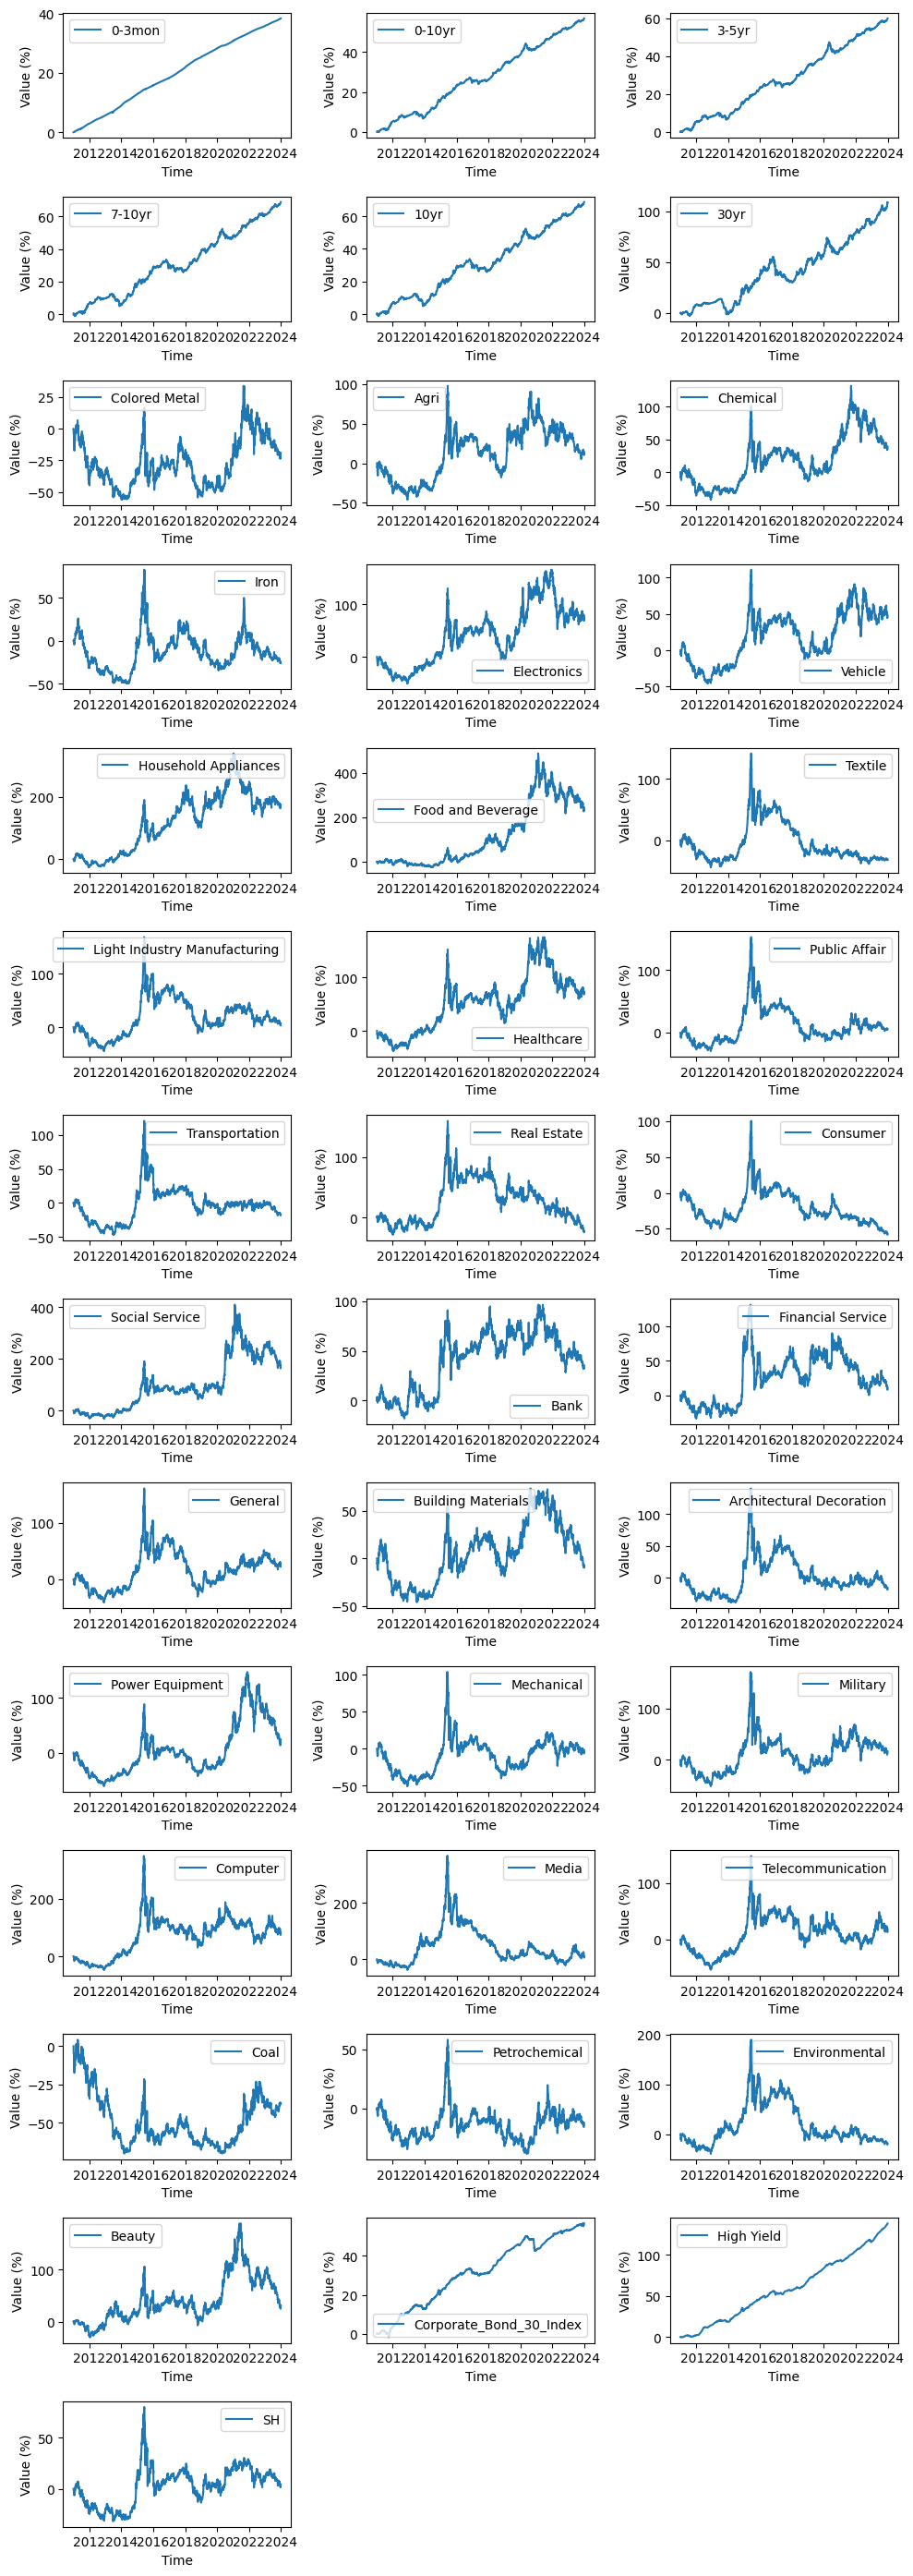

In [ ]:
#plot of return of all assets
import matplotlib.pyplot as plt
def clean_and_convert(value):
    if isinstance(value, (float, int)):
        return value
    cleaned_value = value.replace(',', '')
    return float(cleaned_value)

for col in combined_data.columns:
    combined_data[col] = combined_data[col].apply(clean_and_convert)

cols_per_row = 3

num_assets = len(combined_data.columns)
num_rows = (num_assets + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(10, 2 * num_rows))
axes = axes.flatten()

for i, col in enumerate(combined_data.columns):
    axes[i].plot((combined_data[col] / combined_data[col][0] - 1) * 100, label=col)
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value (%)")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
SH_mod = SH[SH['Date'].isin(common_dates)]['Closing Price']
SH_mod.index = SH.loc[SH['Date'].isin(common_dates), 'Date']



##Compute Business Cycle

In [ ]:
#setting the business cycle signal
path = os.path.join(directory_path, "PMI&CPI.xlsx")
df = pd.read_excel(path)
df.head()
df['PMI_12'] = df['PMI'].shift(12)
df["CPI_pct"] = df['CPI'].pct_change() * 100
df['CPI_pct_MA_12'] = df['CPI_pct'].rolling(window=12, min_periods=1).mean()
df["Growth"] = 0
df["Inflation"] = 0
df["Stage"] = 0
for i in range(0, len(df)):
    if df.at[i, 'PMI'] > 50:
      if df.at[i, 'PMI'] >= df.at[i, 'PMI_12']:
        df.at[i, 'Growth'] = 1  # Record 1 in Growth column if PMI > 50 and increasing
      else:
        df.at[i, 'Growth'] = 2
    elif df.at[i, 'PMI'] < 50:
      if df.at[i, 'PMI'] < df.at[i, 'PMI_12']:
        df.at[i, 'Growth'] = 4 # Record 2 in Growth column if PMI < 50 and decreasing
      else:
        df.at[i, 'Growth'] = 3

    if df.at[i, 'CPI_pct'] >= df.at[i, 'CPI_pct_MA_12']:
        df.at[i, 'Inflation'] = 1  # Record 1 in Inflation column if CPI_pct > MA12
    else:
        df.at[i, 'Inflation'] = 2

    if df.at[i, 'Inflation'] == 1: # inflation increasing
      if df.at[i, 'Growth'] in (1, 2): #, 3):
        df.at[i, 'Stage'] = 4 # expansion
      else:
        df.at[i, 'Stage'] = 3 # stagflation

    if df.at[i, 'Inflation'] == 2: # inflation decreasing
      if df.at[i, 'Growth'] in (1, 2): #, 3):
        df.at[i, 'Stage'] = 2 # recovery
      else:
        df.at[i, 'Stage'] = 1 # recession


In [ ]:
#check the influence of ignorring the case of Growth = 3
filtered_df = df[(df['Inflation'] == 1) & (df['Growth'] == 3)]

# Getting the row numbers (indices) that meet the criteria
row_numbers = filtered_df.index.tolist()
row_numbers

df.iloc[222]

Date              2023-07
PMI                  49.3
CPI              131.9087
PMI_12               49.0
CPI_pct          0.194755
CPI_pct_MA_12   -0.023761
Growth                  3
Inflation               1
Stage                   3
Name: 222, dtype: object

##Visualization of Stages

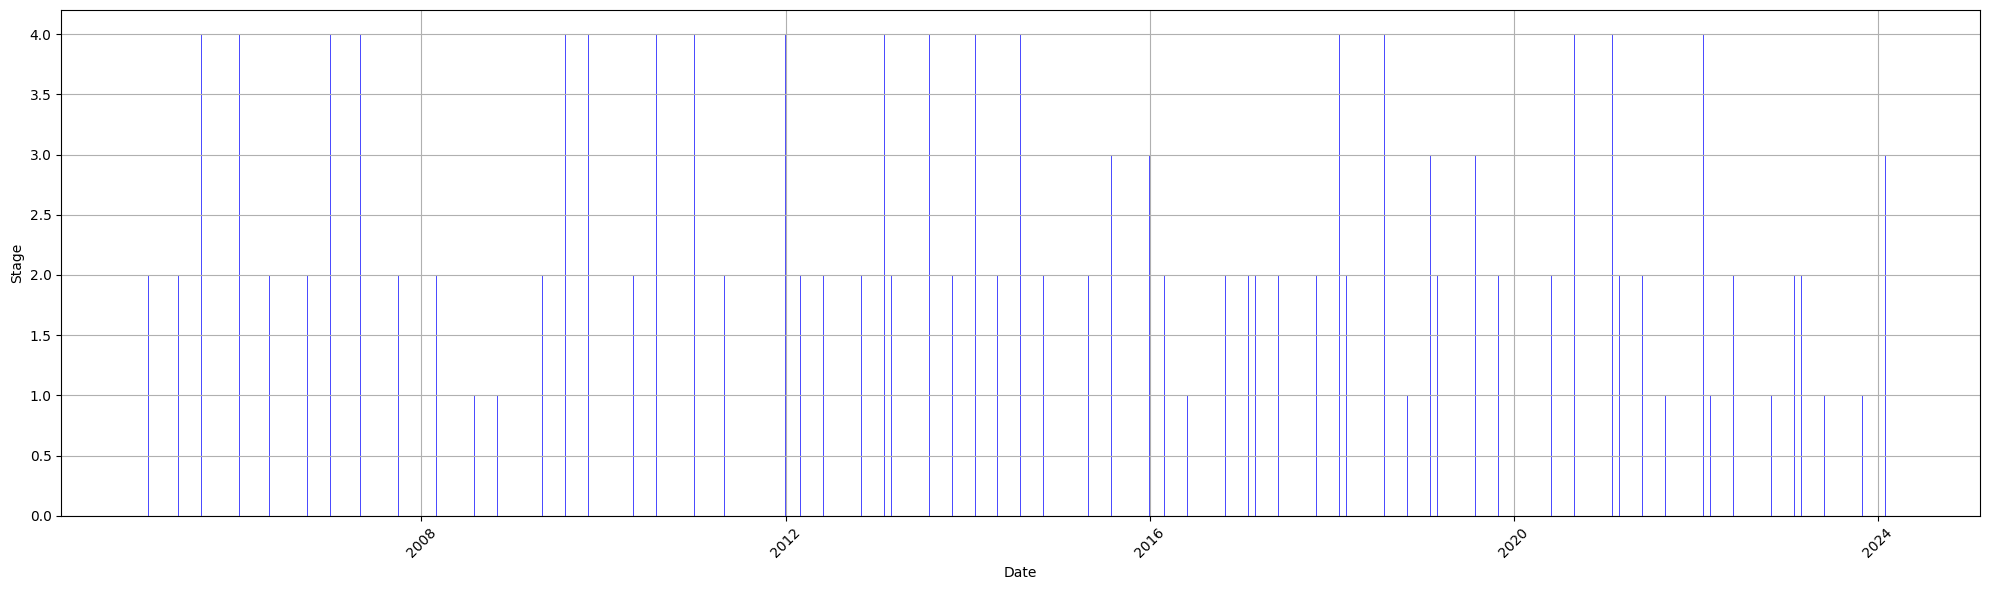

In [ ]:
#Visualization of Stage across the time
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(df)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(20, 6))
plt.bar(df['Date'], df['Stage'], color='blue', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Stage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

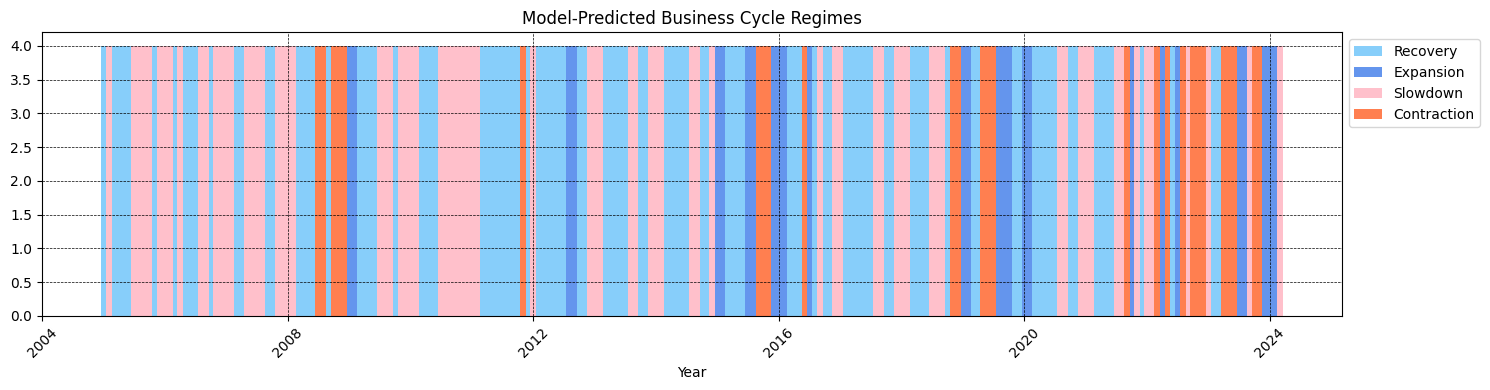

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


regime_data = df[['Date', 'Stage']]

# Mapping regimes to colors
color_mapping = {
    2: 'lightskyblue',
    3: 'cornflowerblue',
    4: 'pink',
    1: 'coral'
}

df['Color'] = df['Stage'].map(color_mapping)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 4))
for stage, color in color_mapping.items():
  if stage == 2:
        ax.bar(df['Date'][df['Stage'] == stage], 4,
           color=color, label='Recovery', width=33)
  elif stage == 3:
        ax.bar(df['Date'][df['Stage'] == stage], 4,
           color=color, label='Expansion', width=33)
  elif stage == 4:
        ax.bar(df['Date'][df['Stage'] == stage], 4,
           color=color, label='Slowdown', width=33)
  else:
        ax.bar(df['Date'][df['Stage'] == stage], 4,
           color=color, label='Contraction', width=33)

ax.set_title('Model-Predicted Business Cycle Regimes')
ax.set_xlabel('Year')
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='black')
ax.axhline(0, color='black', linewidth=0.5)

plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
#number of changing hands
num_change_hands = (df['Stage'] != df['Stage'].shift(1)).sum()
print(f"Number of Changing Hands: {num_change_hands}")


Number of Changing Hands: 96


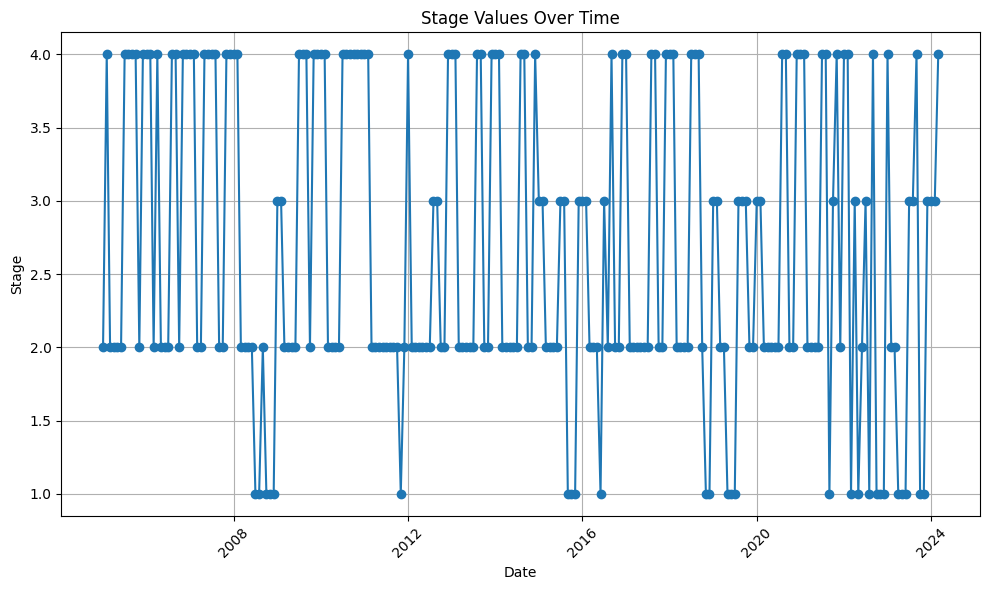

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Stage'], marker='o', linestyle='-')
plt.title('Stage Values Over Time')
plt.xlabel('Date')
plt.ylabel('Stage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Compute Variance, Return

In [ ]:
# Initialize a DataFrame to store the returns
returns_data = pd.DataFrame(index=combined_data.index)

# Calculate the returns for each asset
for column in combined_data.columns[0:]:  # Exclude 'Date' column
    returns_data[column + '_Return'] = combined_data[column].pct_change() * 100

returns_data = returns_data.dropna()
#print(returns_data)


In [ ]:
#Variance-covariance Matrix
# Calculate the variance-covariance matrix of the returns
variance_covariance_matrix = returns_data.cov()

#print("Variance-Covariance Matrix:")
#print(variance_covariance_matrix)


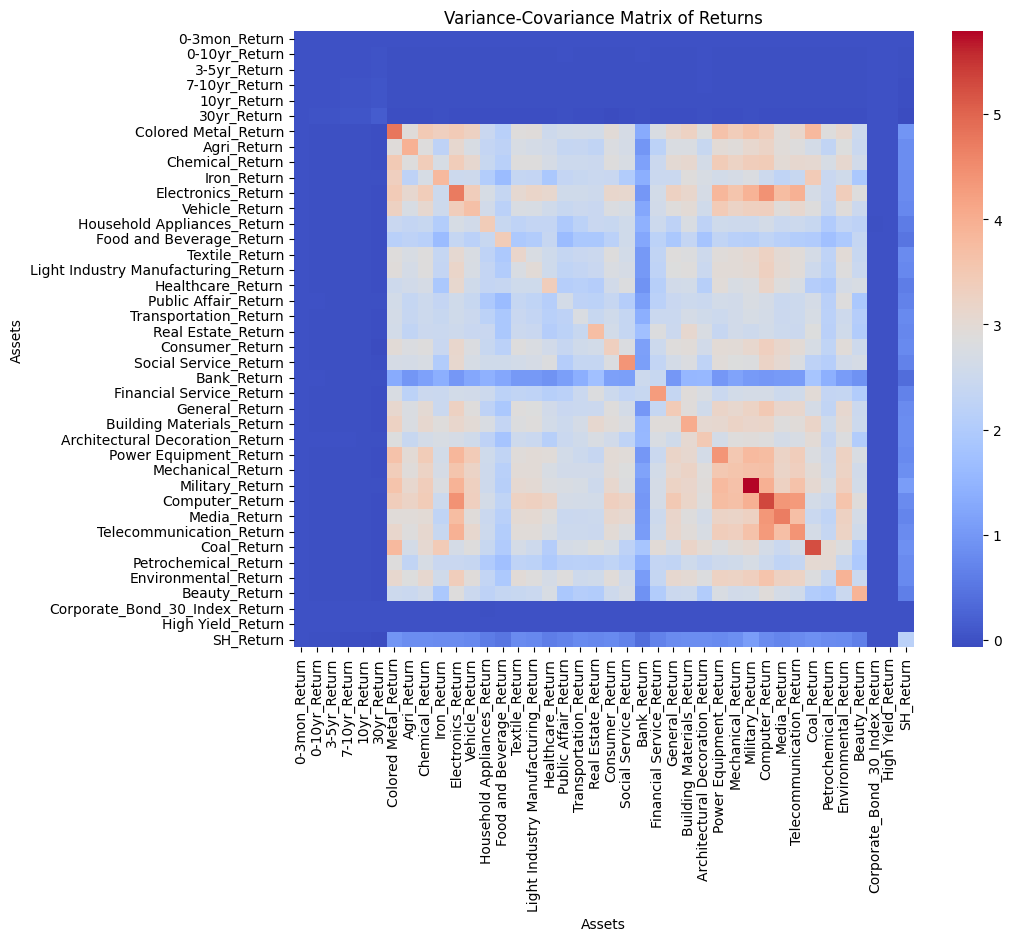

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sns.heatmap(variance_covariance_matrix, cmap='coolwarm')

plt.title('Variance-Covariance Matrix of Returns')
plt.xlabel('Assets')
plt.ylabel('Assets')
plt.show()


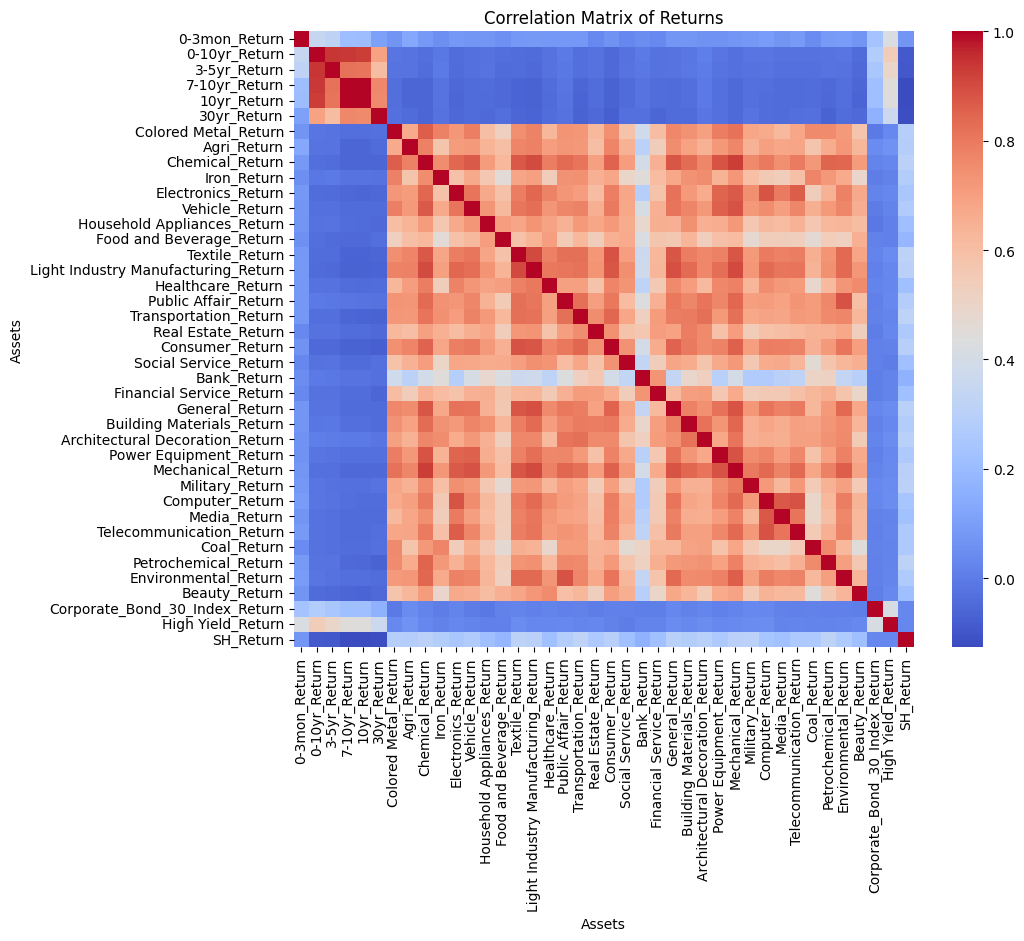

In [ ]:
#correlation chart
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = returns_data.corr()
correlation_matrix

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, cmap='coolwarm')

plt.title('Correlation Matrix of Returns')
plt.xlabel('Assets')
plt.ylabel('Assets')

plt.show()

In [ ]:
##Expand the monthly Stage label into daily label

import pandas as pd
sub_df = df[['Date', 'Stage']].copy()

# Convert 'Date' column to datetime type
sub_df['Date'] = pd.to_datetime(sub_df['Date'])

# Create a new DataFrame with daily dates
start_date = sub_df['Date'].min()  # Minimum date in 'Date' column
end_date = sub_df['Date'].max()  # Maximum date in 'Date' column
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
expanded_df = pd.DataFrame({'Date': date_range})

# Merge 'df' with the expanded DataFrame based on the year and month
expanded_df['Year_Month'] = expanded_df['Date'].dt.to_period('M')
sub_df['Year_Month'] = sub_df['Date'].dt.to_period('M')

# Merge the dataframes on 'Year_Month' to assign the stage value to each day
expanded_df = pd.merge(expanded_df, sub_df[['Year_Month', 'Stage']], on='Year_Month', how='left')

# Drop the 'Year_Month' column if not needed anymore
expanded_df.drop('Year_Month', axis=1, inplace=True)

# Forward fill the 'Stage' column to fill missing values for days without data
expanded_df['Stage'].fillna(method='ffill', inplace=True)

# Display the expanded DataFrame
expanded_df['Date'] = pd.to_datetime(expanded_df['Date'])
common_dates_stage = expanded_df[expanded_df['Date'].isin(common_dates)]
#print(common_dates_stage)



In [ ]:
#Combine the common_dates_stage with the return data.

final_data = pd.merge(returns_data, common_dates_stage, on='Date', how='left')
final_data.pop('SH_Return')
final_data.head()



,Date,0-3mon_Return,0-10yr_Return,3-5yr_Return,7-10yr_Return,10yr_Return,30yr_Return,Colored Metal_Return,Agri_Return,Chemical_Return,...,Computer_Return,Media_Return,Telecommunication_Return,Coal_Return,Petrochemical_Return,Environmental_Return,Beauty_Return,Corporate_Bond_30_Index_Return,High Yield_Return,Stage
0,2011-01-05,0.023561,0.180408,0.154543,0.399750,0.386023,0.396067,0.044292,-1.039641,-0.172462,...,-1.277654,-0.948840,-0.441915,-1.492906,-0.627315,-0.210418,-0.464064,-0.006466,0.180430,4
1,2011-01-06,0.020697,0.009749,-0.022847,-0.092844,-0.076621,-0.076336,-2.491793,-0.796798,-0.771793,...,-0.432566,-0.143424,0.277874,-2.498542,-0.572383,-1.572860,-0.096826,0.135796,0.120697,4
2,2011-01-10,0.010149,0.112823,0.186744,0.088641,0.119204,-0.000895,-1.966219,-3.461682,-2.608308,...,-4.240470,-2.936431,-1.916077,-1.251020,-0.305487,-2.946802,-0.949105,-0.118083,0.131735,4
3,2011-01-11,0.009951,-0.035612,-0.008464,-0.169894,-0.185179,-0.197156,-0.252401,1.014829,0.786986,...,0.535586,0.962751,-0.099589,0.022010,0.566048,-0.516079,1.073589,0.113605,0.049112,4
4,2011-01-12,0.042067,0.029943,0.012742,0.027097,0.020473,0.124089,-0.812848,-0.157639,0.384439,...,0.576670,-0.307603,0.175765,0.146700,0.946870,-0.118957,0.631020,0.059044,0.012187,4


1


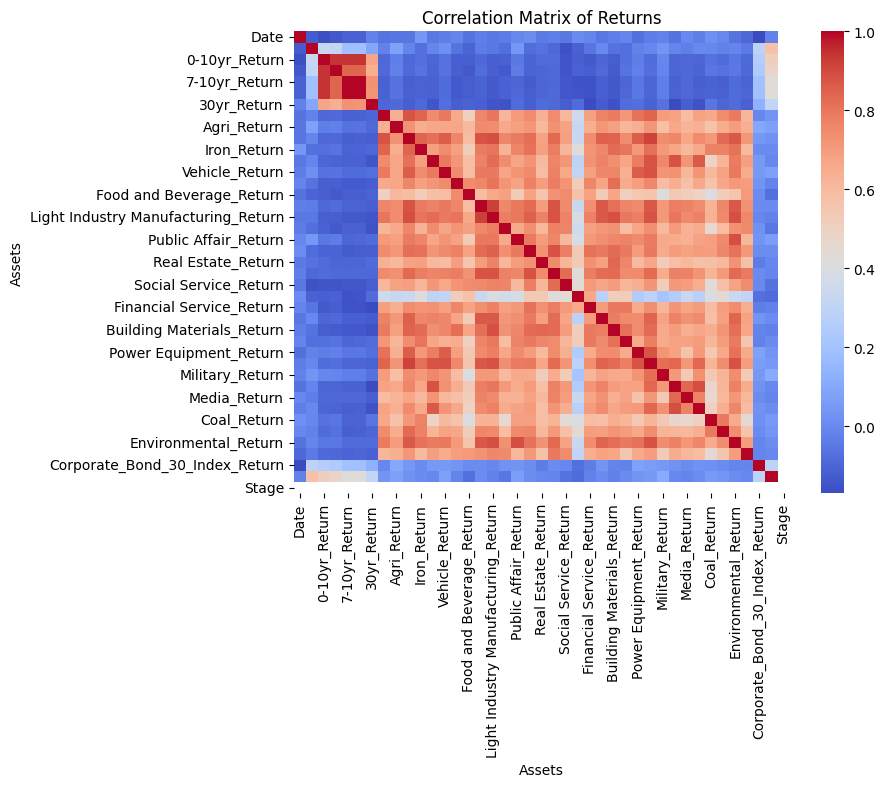

2


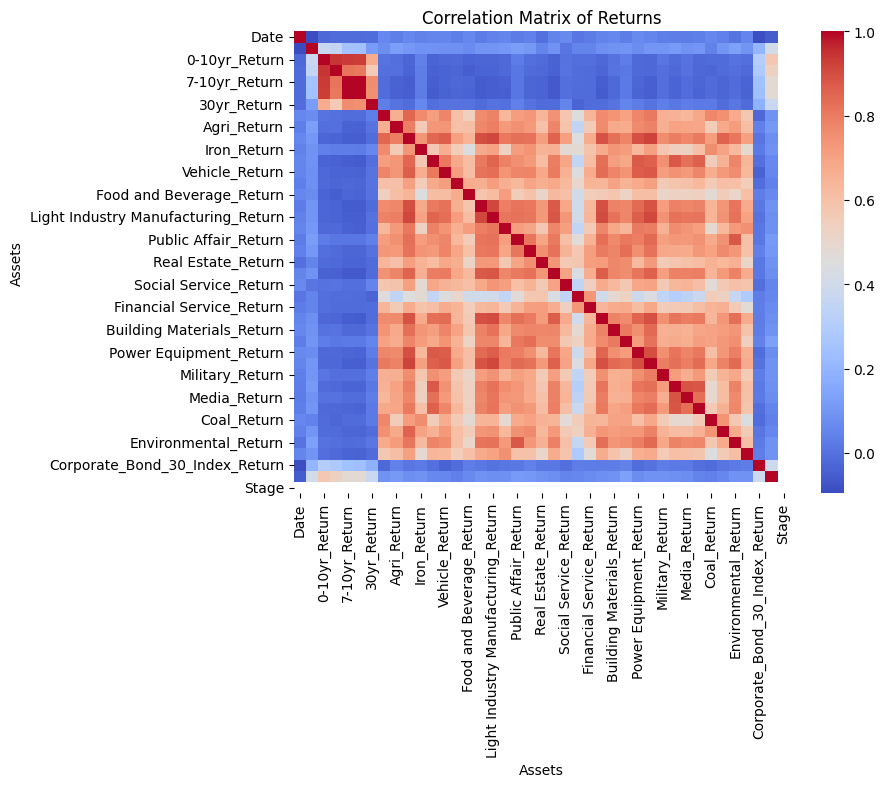

3


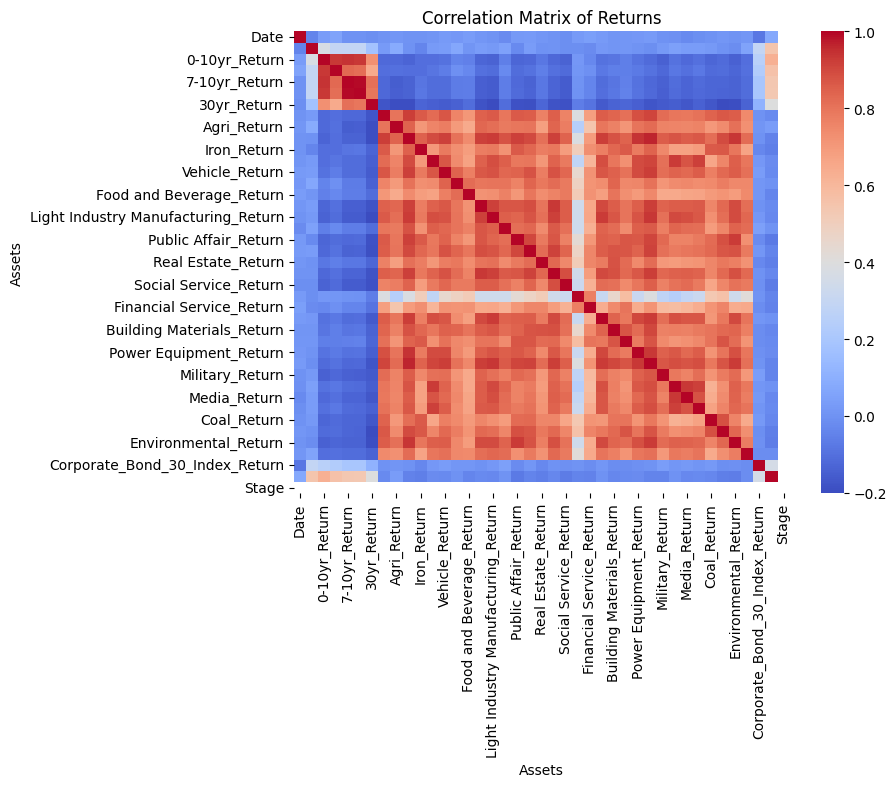

4


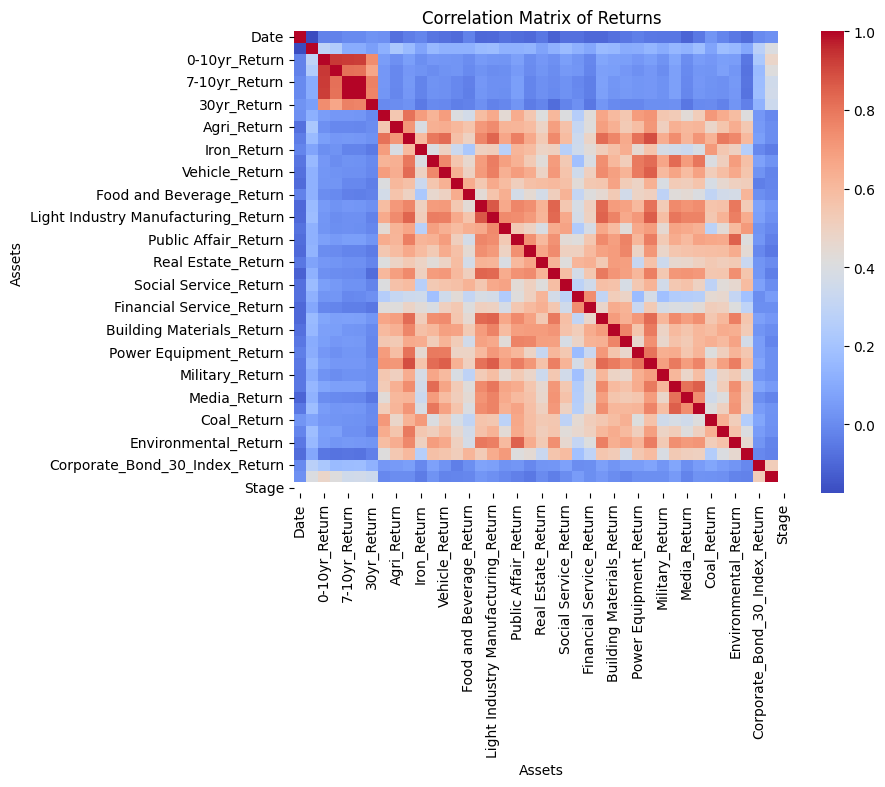

In [ ]:
#Redo the covariance matrix and correlation table of returns under each economics stage.

for i in range(1,5):
  print(i)
  data = final_data[final_data['Stage'] == i]
  correlation_matrix = data.corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, cmap='coolwarm')

  plt.title('Correlation Matrix of Returns')
  plt.xlabel('Assets')
  plt.ylabel('Assets')
  plt.show()

  covariance_matrix = data.cov()
  #print(covariance_matrix)





##Benchmark Portfolio


In [ ]:
split_index = int(len(final_data) * 0.7)

train_data = final_data[:split_index]
test_data = final_data[split_index:]

# Output the result to check
print(f"Training Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Training Data Length: 1742
Test Data Length: 747


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Define the Sharpe Ratio calculation function
def sharpe_ratio(weights, returns, risk_free_rate=0.02):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_std_dev  # Negative for minimization

# Function to perform optimization for a given stage
def optimize_portfolio(df, stage):
    stage_data = df[df['Stage'] == stage].iloc[:, 1:-1]
    num_assets = stage_data.shape[1]
    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0.005, 0.5) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    result = minimize(sharpe_ratio, initial_weights, args=(stage_data, 0.02), method='SLSQP', bounds=bounds, constraints=constraints)
    r = np.sum(stage_data.mean() * result.x) * 252
    print(r)
    return result

def optimize_portfolio_global(df):
    stage_data = df.iloc[:, 1:-1]
    num_assets = stage_data.shape[1]
    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0.005, 0.5) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    result = minimize(sharpe_ratio, initial_weights, args=(stage_data, 0.02), method='SLSQP', bounds=bounds, constraints=constraints)
    r = np.sum(stage_data.mean() * result.x) * 252
    print(r)
    return result

#Markowitz optimization model
# Run the optimization for each unique stage in the dataset
unique_stages = train_data['Stage'].unique()
optimized_weights = {}

for stage in unique_stages:
    result = optimize_portfolio(train_data, stage)
    optimized_weights[stage] = result.x  # Store the optimal weights
    print(f"Optimal weights for stage {stage}: {result.x}")
    print(f"Expected Sharpe Ratio: {-result.fun}\n")

benchmark_weights = optimize_portfolio_global(train_data).x

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


10.632486706527807
Optimal weights for stage 4: [0.27900614 0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.04099386 0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.5       ]
Expected Sharpe Ratio: 2.475793269419755

6.3202926669116035
Optimal weights for stage 2: [0.005      0.005      0.005      0.005      0.005      0.02690422
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.29309578 0.5       ]
Expected Sharpe Ratio: 1.549047471000045

1

In [ ]:
train_data.columns


Index(['Date', '0-3mon_Return', '0-10yr_Return', '3-5yr_Return',
       '7-10yr_Return', '10yr_Return', '30yr_Return', 'Colored Metal_Return',
       'Agri_Return', 'Chemical_Return', 'Iron_Return', 'Electronics_Return',
       'Vehicle_Return', 'Household Appliances_Return',
       'Food and Beverage_Return', 'Textile_Return',
       'Light Industry Manufacturing_Return', 'Healthcare_Return',
       'Public Affair_Return', 'Transportation_Return', 'Real Estate_Return',
       'Consumer_Return', 'Social Service_Return', 'Bank_Return',
       'Financial Service_Return', 'General_Return',
       'Building Materials_Return', 'Architectural Decoration_Return',
       'Power Equipment_Return', 'Mechanical_Return', 'Military_Return',
       'Computer_Return', 'Media_Return', 'Telecommunication_Return',
       'Coal_Return', 'Petrochemical_Return', 'Environmental_Return',
       'Beauty_Return', 'Corporate_Bond_30_Index_Return', 'High Yield_Return',
       'Stage'],
      dtype='object')

In [ ]:

# Function to calculate daily returns
def calculate_daily_returns(df, weights_dict):
    daily_returns = []
    for index, row in df.iterrows():
        stage = row['Stage']
        weights = weights_dict[stage]
        asset_returns = row.iloc[1:-1].values
        daily_return = np.dot(asset_returns, weights)
        daily_returns.append(daily_return)
    return daily_returns

# Calculate daily returns using the optimized weights
daily_returns_list = calculate_daily_returns(final_data, optimized_weights)

returns_df = pd.DataFrame({
    'Date': final_data['Date'],
    'Daily Returns': daily_returns_list
})


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


returns_df['Daily Returns'] = returns_df['Daily Returns'] / 100

# Calculate cumulative returns
returns_df['Cumulative Return'] = (1 + returns_df['Daily Returns']).cumprod()

final_cumulative_return = returns_df['Cumulative Return'].iloc[-1]
print(f"Final Cumulative Return: {final_cumulative_return}")


Final Cumulative Return: 2.3332169760845103


In [ ]:
# Calculate daily returns for an equally weighted portfolio
num_assets = len(final_data.columns) - 2
equal_weights = np.ones(num_assets) / num_assets

# Calculate the daily return for the equally weighted portfolio
equal_weighted_daily_returns = final_data.iloc[:, 1:-1].dot(equal_weights) / 100

# Calculate cumulative returns for the equally weighted portfolio
equal_weighted_cumulative_returns = (1 + equal_weighted_daily_returns).cumprod()


In [ ]:
#60% equity - 40% bond model

e = 0.6/31
b = 0.4/8
weights_60_40_weights = [b, b, b, b, b, b, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, e, b, b]
weights_60_40_daily_returns = final_data.iloc[:, 1:-1].dot(weights_60_40_weights)
weights_60_40_cumulative_returns = (1 + weights_60_40_daily_returns/100).cumprod()

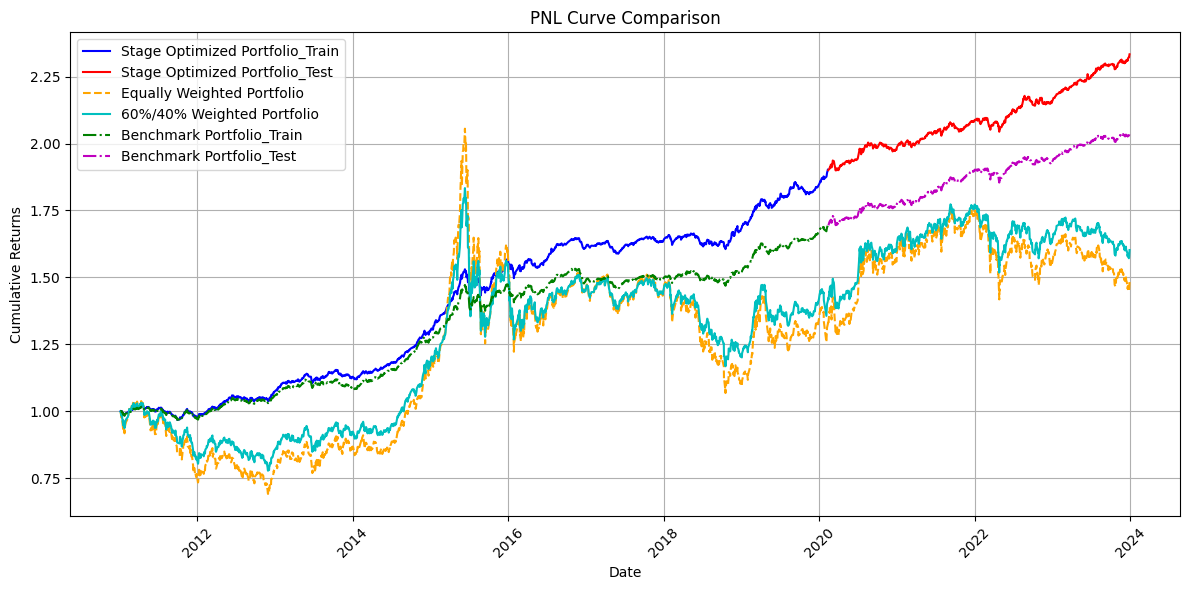

Final Cumulative Return for Benchmark Portfolio: 2.0426216460565967


In [ ]:
benchmark_daily_returns = final_data.iloc[:, 1:-1].dot(benchmark_weights)

# Convert daily returns to cumulative returns for the benchmark model
benchmark_cumulative_returns = (1 + benchmark_daily_returns/100).cumprod()

plt.figure(figsize=(12, 6))

# Train data in blue
plt.plot(returns_df['Date'][:split_index], returns_df['Cumulative Return'][:split_index], label='Stage Optimized Portfolio_Train', color='blue')
plt.plot(returns_df['Date'][split_index:], returns_df['Cumulative Return'][split_index:], label='Stage Optimized Portfolio_Test', color='red')

# Plot the PNL curve for the equally weighted portfolio
plt.plot(returns_df['Date'], equal_weighted_cumulative_returns, label='Equally Weighted Portfolio', color='orange', linestyle='--')

# Plot the PNL curve for the 60/40 weighted portfolio
plt.plot(returns_df['Date'], weights_60_40_cumulative_returns, label='60%/40% Weighted Portfolio', color='c', linestyle='-')

# Plot the PNL curve for the benchmark model using the provided weights
plt.plot(returns_df['Date'][:split_index], benchmark_cumulative_returns[:split_index], label='Benchmark Portfolio_Train', color='green', linestyle='-.')
plt.plot(returns_df['Date'][split_index:], benchmark_cumulative_returns[split_index:], label='Benchmark Portfolio_Test', color='m', linestyle='-.')

# Add title and labels
plt.title('PNL Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate the cumulative return at the end of the period
final_benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1]
print(f"Final Cumulative Return for Benchmark Portfolio: {final_benchmark_cumulative_return}")

##Optimization using Black Litterman Model

In [ ]:
!pip install pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
final_data.columns

Index(['Date', '0-3mon_Return', '0-10yr_Return', '3-5yr_Return',
       '7-10yr_Return', '10yr_Return', '30yr_Return', 'Colored Metal_Return',
       'Agri_Return', 'Chemical_Return', 'Iron_Return', 'Electronics_Return',
       'Vehicle_Return', 'Household Appliances_Return',
       'Food and Beverage_Return', 'Textile_Return',
       'Light Industry Manufacturing_Return', 'Healthcare_Return',
       'Public Affair_Return', 'Transportation_Return', 'Real Estate_Return',
       'Consumer_Return', 'Social Service_Return', 'Bank_Return',
       'Financial Service_Return', 'General_Return',
       'Building Materials_Return', 'Architectural Decoration_Return',
       'Power Equipment_Return', 'Mechanical_Return', 'Military_Return',
       'Computer_Return', 'Media_Return', 'Telecommunication_Return',
       'Coal_Return', 'Petrochemical_Return', 'Environmental_Return',
       'Beauty_Return', 'Corporate_Bond_30_Index_Return', 'High Yield_Return',
       'Stage'],
      dtype='object')

In [ ]:
#Compute the average performance of each asset under each stage to distinguish the favourable asset and form a view
mean_return = train_data.groupby('Stage').agg({col: ['mean'] for col in data.columns if col != "Date" and col != 'Stage'})

def top_bottom_assets(df):
    top_bottom_dict = {}
    for stage in df.index:
        sorted_assets = df.loc[stage].sort_values()
        bottom_5 = sorted_assets.head(5)
        top_5 = sorted_assets.tail(5).sort_values(ascending=False)
        top_bottom_dict[stage] = {'Top 5 Assets': top_5, 'Bottom 5 Assets': bottom_5}
    return top_bottom_dict

top_bottom_results = top_bottom_assets(mean_return)

for stage, assets in top_bottom_results.items():
    print(f"Stage {stage}:")
    print("Top 5 Assets:")
    print(assets['Top 5 Assets'])
    print("\nBottom 5 Assets:")
    print(assets['Bottom 5 Assets'])
    print("\n")

Stage 1:
Top 5 Assets:
Beauty_Return          mean    0.222366
Social Service_Return  mean    0.209457
Computer_Return        mean    0.203530
Agri_Return            mean    0.196890
Electronics_Return     mean    0.190083
Name: 1, dtype: float64

Bottom 5 Assets:
Iron_Return            mean   -0.309377
Petrochemical_Return   mean   -0.131779
Coal_Return            mean   -0.117335
Bank_Return            mean   -0.067275
Transportation_Return  mean   -0.051402
Name: 1, dtype: float64


Stage 2:
Top 5 Assets:
Household Appliances_Return  mean    0.091378
Food and Beverage_Return     mean    0.071818
Real Estate_Return           mean    0.065114
Computer_Return              mean    0.046976
Healthcare_Return            mean    0.041765
Name: 2, dtype: float64

Bottom 5 Assets:
Colored Metal_Return    mean   -0.040866
Military_Return         mean   -0.039871
Coal_Return             mean   -0.039848
Consumer_Return         mean   -0.036263
Power Equipment_Return  mean   -0.035001
Name: 2, 

In [ ]:
import numpy as np
import pandas as pd
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Assuming train_data is already loaded and contains 'Stage', 'Date', and asset return columns
unique_stages = train_data['Stage'].unique()
risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
bl_weights = {}  # Dictionary to store weights by stage

# Extract asset names from the DataFrame (ensure this matches the order used in your BL model)
asset_names = train_data.columns[1:-1]  # Adjust the slicing as necessary to match the asset return columns

for stage in unique_stages:
    print(f"Processing stage: {stage}")
    stage_data = train_data[train_data['Stage'] == stage].iloc[:, 1:-1]  # Adjust if necessary to correctly select data columns

    # Calculate mean returns and covariance matrix, annualized
    mean_returns = stage_data.mean() * 252
    cov_matrix = stage_data.cov() * 252

    # Define the views matrix P and the views vector Q based on the stage
    if stage == 1:
        P = np.zeros((2, len(asset_names)))  # Two views for stage 1
        P[0, asset_names.get_loc('Electronics_Return')] = 1
        P[0, asset_names.get_loc('Iron_Return')] = -1
        P[1, asset_names.get_loc('Computer_Return')] = 1
        P[1, asset_names.get_loc('Coal_Return')] = -1
        Q = np.array([0.5, 0.4])  # Two views
    elif stage == 2:
        P = np.zeros((1, len(asset_names)))  # One view for stage 2
        P[0, asset_names.get_loc('Household Appliances_Return')] = 1
        P[0, asset_names.get_loc('High Yield_Return')] = -1
        Q = np.array([0.25])  # One view
    elif stage == 3:
        P = np.zeros((1, len(asset_names)))  # One view for stage 3
        P[0, asset_names.get_loc('Financial Service_Return')] = 1
        P[0, asset_names.get_loc('Transportation_Return')] = -1
        Q = np.array([0.2])  # One view
    elif stage == 4:
        P = np.zeros((1, len(asset_names)))  # One view for stage 4
        P[0, asset_names.get_loc('Social Service_Return')] = 1
        P[0, asset_names.get_loc('Architectural Decoration_Return')] = -1
        Q = np.array([0.3])  # One view
    # Define the uncertainty in the views (Omega)
    # The length of Q determines the required size of Omega
    tau = 0.1  # Scale factor for the uncertainty
    Omega = np.diag(np.diag(P.dot(cov_matrix).dot(P.T)) * tau)  # Properly size Omega to match number of views

    # Initialize the Black-Litterman model
    bl = BlackLittermanModel(cov_matrix, pi=mean_returns, Q=Q, P=P, omega=Omega,
                             risk_free_rate=risk_free_rate)

    # Generate expected returns and the covariance matrix from the BL model
    bl_return = bl.bl_returns()
    bl_cov = bl.bl_cov()

    # Optimize portfolio using Efficient Frontier
    ef = EfficientFrontier(bl_return, bl_cov)
    ef.add_constraint(lambda x: x >= 0.005)  # Minimum weight constraint
    ef.add_constraint(lambda x: x <= 0.5)  # Max weight constraint
    ef.add_constraint(lambda x: sum(x) == 1)  # Weights must sum to 1

    # Maximize the Sharpe ratio
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # Convert cleaned_weights dictionary to an ordered array
    weight_array = np.array([cleaned_weights.get(asset, 0) for asset in asset_names])

    bl_weights[stage] = weight_array  # Save the array of weights by stage

    print(f"Optimized Weights for stage {stage}: {weight_array}")


Processing stage: 4
Optimized Weights for stage 4: [0.27514 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.04486 0.005   0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.005   0.5    ]
Processing stage: 2
Optimized Weights for stage 2: [0.005   0.005   0.005   0.005   0.005   0.03407 0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
 0.005   0.28593 0.5    ]
Processing stage: 1
Optimized Weights for stage 1: [0.005 0.005 0.005 0.005 0.315 0.5   0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0

In [ ]:
train_data.columns

Index(['Date', '0-3mon_Return', '0-10yr_Return', '3-5yr_Return',
       '7-10yr_Return', '10yr_Return', '30yr_Return', 'Colored Metal_Return',
       'Agri_Return', 'Chemical_Return', 'Iron_Return', 'Electronics_Return',
       'Vehicle_Return', 'Household Appliances_Return',
       'Food and Beverage_Return', 'Textile_Return',
       'Light Industry Manufacturing_Return', 'Healthcare_Return',
       'Public Affair_Return', 'Transportation_Return', 'Real Estate_Return',
       'Consumer_Return', 'Social Service_Return', 'Bank_Return',
       'Financial Service_Return', 'General_Return',
       'Building Materials_Return', 'Architectural Decoration_Return',
       'Power Equipment_Return', 'Mechanical_Return', 'Military_Return',
       'Computer_Return', 'Media_Return', 'Telecommunication_Return',
       'Coal_Return', 'Petrochemical_Return', 'Environmental_Return',
       'Beauty_Return', 'Corporate_Bond_30_Index_Return', 'High Yield_Return',
       'Stage'],
      dtype='object')

In [ ]:
bl_daily_returns_list = calculate_daily_returns(final_data, bl_weights)

# Creating a DataFrame for daily returns
bl_returns_df = pd.DataFrame({
    'Date': final_data['Date'],
    'Daily Returns': bl_daily_returns_list
})

bl_returns_df['Daily Returns'] = bl_returns_df['Daily Returns'] / 100  # Remove this line if already in decimal form

# Calculate cumulative returns
bl_returns_df['Cumulative Return'] = (1 + bl_returns_df['Daily Returns']).cumprod()

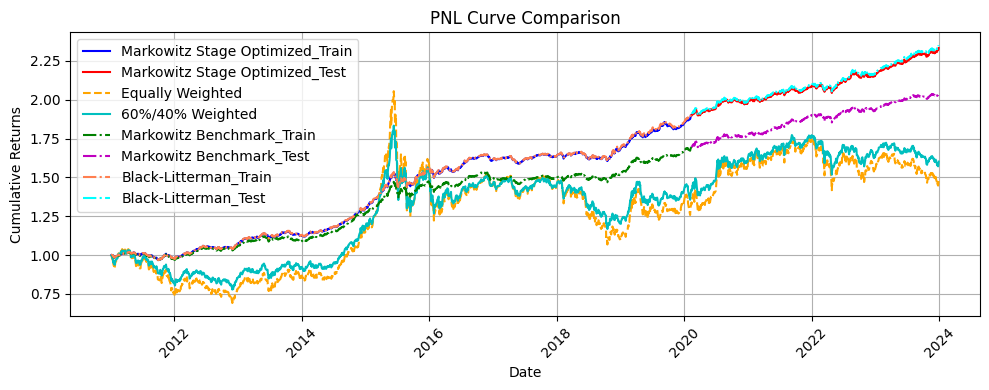

Final Cumulative Return for Benchmark Portfolio: 2.0426216460565967


In [ ]:

# Plotting the PNL curves
plt.figure(figsize=(10, 4))

# Train data in blue
plt.plot(returns_df['Date'][:split_index], returns_df['Cumulative Return'][:split_index], label='Markowitz Stage Optimized_Train', color='blue')
plt.plot(returns_df['Date'][split_index:], returns_df['Cumulative Return'][split_index:], label='Markowitz Stage Optimized_Test', color='red')

# Plot the PNL curve for the equally weighted portfolio
plt.plot(returns_df['Date'], equal_weighted_cumulative_returns, label='Equally Weighted', color='orange', linestyle='--')

# Plot the PNL curve for the 60%/40% weighted portfolio
plt.plot(returns_df['Date'], weights_60_40_cumulative_returns, label='60%/40% Weighted', color='c', linestyle='-')

# Plot the PNL curve for the benchmark model using the provided weights
plt.plot(returns_df['Date'][:split_index], benchmark_cumulative_returns[:split_index], label='Markowitz Benchmark_Train', color='green', linestyle='-.')
plt.plot(returns_df['Date'][split_index:], benchmark_cumulative_returns[split_index:], label='Markowitz Benchmark_Test', color='m', linestyle='-.')

# Plot the PNL curve for the blacklitterman model using the provided weights
plt.plot(returns_df['Date'][:split_index], bl_returns_df['Cumulative Return'][:split_index], label='Black-Litterman_Train', color='coral', linestyle='dashdot')
plt.plot(returns_df['Date'][split_index:], bl_returns_df['Cumulative Return'][split_index:], label='Black-Litterman_Test', color='cyan', linestyle='dashdot')

# Add title and labels
plt.title('PNL Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

# Rotate dates on x-axis for better visibility
plt.xticks(rotation=45)

# Ensure layout is tight so no information is cut off
plt.tight_layout()

# Show the plot
plt.show()

# Calculate the cumulative return at the end of the period
final_benchmark_cumulative_return = benchmark_cumulative_returns.iloc[-1]
print(f"Final Cumulative Return for Benchmark Portfolio: {final_benchmark_cumulative_return}")

In [ ]:
# Compute the sharpe ratio of each model
bl_portfolio_std_dev = np.sqrt(bl_returns_df['Daily Returns'].var() * 252)
bl_sharpe = (bl_returns_df['Daily Returns'].mean()*252 - 0.02) / bl_portfolio_std_dev
print(f"Black Litterman Sharpe: {bl_sharpe}")


portfolio_std_dev = np.sqrt(returns_df['Daily Returns'].var() * 252)
stage_sharpe = (returns_df['Daily Returns'].mean()*252 - 0.02) / portfolio_std_dev
print(f"Stage Optimized Portfolio Sharpe: {stage_sharpe}")


bench_portfolio_std_dev = np.sqrt(benchmark_daily_returns.var() * 252)
bench_sharpe = (benchmark_daily_returns.mean()*252 - 0.02) / bench_portfolio_std_dev
print(f"Benchmark Model Sharpe: {bench_sharpe}")


Black Litterman Sharpe: 1.5138951487456298
Stage Optimized Portfolio Sharpe: 1.5068036289247289
Benchmark Model Sharpe: 1.7246199069785928


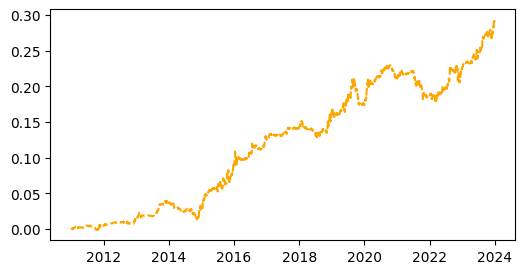

In [ ]:
plt.figure(figsize=(6, 3))

#Spread between Stage Optimized model and benchmark model
a = returns_df['Cumulative Return'] - benchmark_cumulative_returns
plt.plot(returns_df['Date'], a, label='Difference', color='orange', linestyle='--')


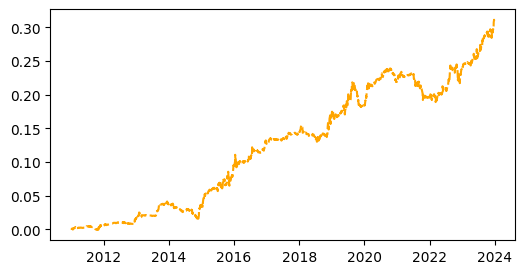

In [ ]:
plt.figure(figsize=(6, 3))

#Spread between Black Litterman model and benchmark model
b = bl_returns_df['Cumulative Return'] - benchmark_cumulative_returns
plt.plot(returns_df['Date'], b, color='orange', linestyle='--')


Text(0, 0.5, 'Return Spread')

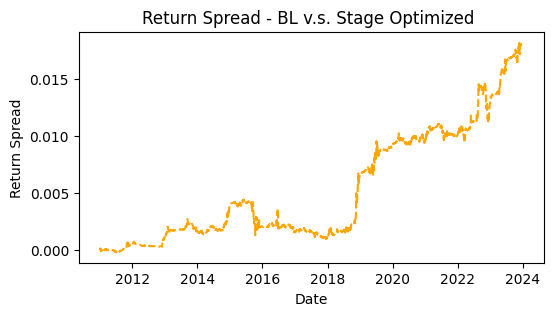

In [ ]:
plt.figure(figsize=(6, 3))

#Spread between Black Litterman model and Stage Optimized model
b = bl_returns_df['Cumulative Return'] - returns_df['Cumulative Return']
plt.plot(returns_df['Date'], b, color='orange', linestyle='--')
plt.title('Return Spread - BL v.s. Stage Optimized ')
plt.xlabel('Date')
plt.ylabel('Return Spread')

#Chart

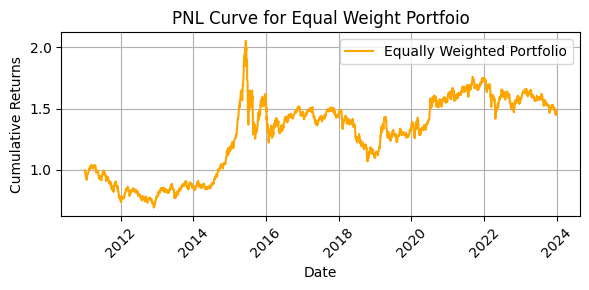

In [ ]:
plt.figure(figsize=(6, 3))

# Plot the PNL curve for the equally weighted portfolio
plt.plot(returns_df['Date'], equal_weighted_cumulative_returns, label='Equally Weighted Portfolio', color='orange', linestyle='-')
# Add title and labels
plt.title('PNL Curve for Equal Weight Portfoio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

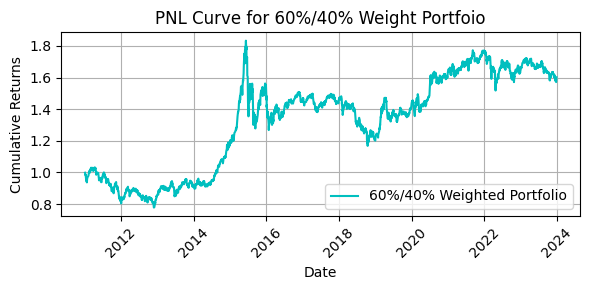

In [ ]:
plt.figure(figsize=(6, 3))
# Plot the PNL curve for the 60%/40% weighted portfolio
plt.plot(returns_df['Date'], weights_60_40_cumulative_returns, label='60%/40% Weighted Portfolio', color='c', linestyle='-')
# Add title and labels
plt.title('PNL Curve for 60%/40% Weight Portfoio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

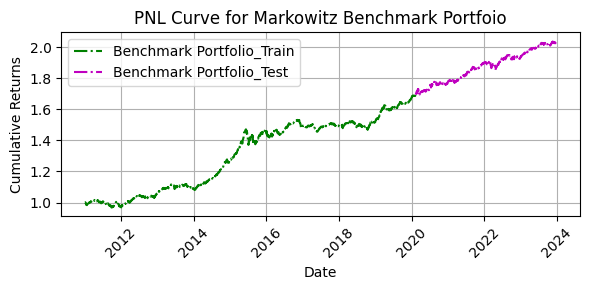

In [ ]:
plt.figure(figsize=(6, 3))
# Plot the PNL curve for the benchmark model using the provided weights
plt.plot(returns_df['Date'][:split_index], benchmark_cumulative_returns[:split_index], label='Benchmark Portfolio_Train', color='green', linestyle='-.')
plt.plot(returns_df['Date'][split_index:], benchmark_cumulative_returns[split_index:], label='Benchmark Portfolio_Test', color='m', linestyle='-.')
# Add title and labels
plt.title('PNL Curve for Markowitz Benchmark Portfoio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

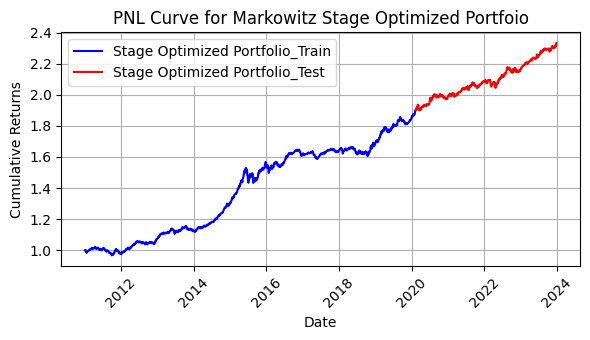

In [ ]:
plt.figure(figsize=(6, 3.5))
# Plot the PNL curve for the stage optimized benchmark model using the provided weights
plt.plot(returns_df['Date'][:split_index], returns_df['Cumulative Return'][:split_index], label='Stage Optimized Portfolio_Train', color='blue')
plt.plot(returns_df['Date'][split_index:], returns_df['Cumulative Return'][split_index:], label='Stage Optimized Portfolio_Test', color='red')

# Add title and labels
plt.title('PNL Curve for Markowitz Stage Optimized Portfoio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

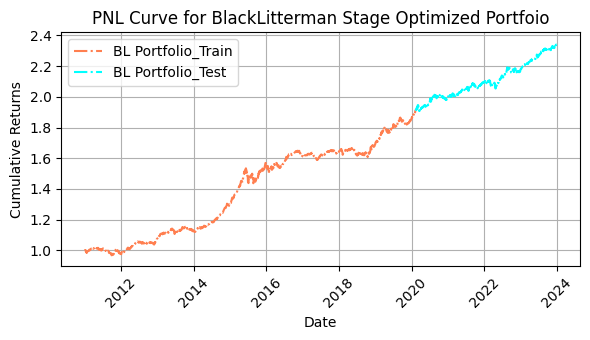

In [ ]:
plt.figure(figsize=(6, 3.5))

# Plot the PNL curve for the blacklitterman model using the provided weights
plt.plot(returns_df['Date'][:split_index], bl_returns_df['Cumulative Return'][:split_index], label='BL Portfolio_Train', color='coral', linestyle='dashdot')
plt.plot(returns_df['Date'][split_index:], bl_returns_df['Cumulative Return'][split_index:], label='BL Portfolio_Test', color='cyan', linestyle='dashdot')

# Add title and labels
plt.title('PNL Curve for BlackLitterman Stage Optimized Portfoio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Add grid and legend
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#Sharpe Calculation


In [ ]:
# Compute the sharpe ratio of each model
eq_portfolio_std_dev = np.sqrt(equal_weighted_daily_returns.var() * 252)
eq_sharpe = (equal_weighted_daily_returns.mean()*252 - 0.02) / eq_portfolio_std_dev
print(f"Equal Weight Portfolio Sharpe: {eq_sharpe}")

w_60_40_std_dev = np.sqrt(weights_60_40_daily_returns.var() * 252)
w_60_40_sharpe = (weights_60_40_daily_returns.mean()*252 - 0.02) / w_60_40_std_dev
print(f"60%/40% Portfolio Sharpe: {w_60_40_sharpe}")

bench_portfolio_std_dev = np.sqrt(benchmark_daily_returns.var() * 252)
bench_sharpe = (benchmark_daily_returns.mean()*252 - 0.02) / bench_portfolio_std_dev
print(f"Benchmark Markowitz Model Sharpe: {bench_sharpe}")

portfolio_std_dev = np.sqrt(returns_df['Daily Returns'].var() * 252)
stage_sharpe = (returns_df['Daily Returns'].mean()*252 - 0.02) / portfolio_std_dev
print(f"Stage Optimized Markowitz Portfolio Sharpe: {stage_sharpe}")

bl_portfolio_std_dev = np.sqrt(bl_returns_df['Daily Returns'].var() * 252)
bl_sharpe = (bl_returns_df['Daily Returns'].mean()*252 - 0.02) / bl_portfolio_std_dev
print(f"Black Litterman Sharpe: {bl_sharpe}")

Equal Weight Portfolio Sharpe: 0.20079017407015864
60%/40% Portfolio Sharpe: 0.3845169579156899
Benchmark Markowitz Model Sharpe: 1.7246199069785928
Stage Optimized Markowitz Portfolio Sharpe: 1.5068036289247289
Black Litterman Sharpe: 1.5138951487456298
